In [1]:
import sys
sys.path.append("../../src")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pickle
import pandas as pd
import subprocess
from time import time
import matplotlib.tri as tri
from copy import deepcopy
from sindy_utils import *
import os

data_path = './data'
if not os.path.exists(data_path): os.makedirs(data_path)

In [2]:
plot_fig = True
save_data = True
tstop = 0.3
dt = 5e-3
nt = int(tstop / dt + 1)
t = np.linspace(0, tstop, nt)
x0 = 0.5
kappa = 0.5
alpha = 0.01

# parameters
p1_arr = np.array([4.0]) # width of initial condition
p2_arr = np.array([1.0]) # height of initial condition

# p1_arr = np.linspace(4.0, 4.3, 2)
# p2_arr = np.linspace(1.0, 1.4, 2)


params = {}
params['pde'] = {}
params['pde']['exe_file'] = '../../src/ex16'
params['pde']['m_file'] = './ref-square.mesh'
params['pde']['u_file'] = './ex16-u_pred.gf'
params['pde']['res_file'] = "./ex16-residual.gf"
params['pde']['rl'] = 5
params['pde']['order'] = 1
params['pde']['ODEsolver'] = 1 # 1 - Backward Euler, 2 - SDIRK2, 3 - SDIRK3
params['pde']['tstop'] = tstop
params['pde']['dt'] = dt
params['pde']['x1'] = x0
params['pde']['x2'] = x0
params['pde']['kappa'] = kappa
params['pde']['alpha'] = alpha
# params['pde']['res_ns'] = 0.1   # percentage of time steps for residual evaluation
# params['pde']['Tmax_iter'] = 30 # max number of CG iterations in Tsolver

In [3]:
def plot_u(u, du):
    vmin_x = u.min()
    vmax_x = u.max()
    vmin_dx = du.min()/4
    vmax_dx = du.max()/4
    
    fig = plt.figure(figsize=(18,3))
    ax = fig.add_subplot(151)
    ax.set_aspect('equal')
    plt.axis('off')
    ax.set_title(f'u - time: {0}')
    tpc = ax.tripcolor(triang, u[0], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
    fig.colorbar(tpc, ax=ax)
    
    ax = fig.add_subplot(152)
    ax.set_aspect('equal')
    plt.axis('off')
    ax.set_title(f'u - time: {5}')
    tpc = ax.tripcolor(triang, u[5], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
    fig.colorbar(tpc, ax=ax)
    
    ax = fig.add_subplot(153)
    ax.set_aspect('equal')
    plt.axis('off')
    ax.set_title(f'du - time: {0}')
    tpc = ax.tripcolor(triang, du[0], shading='gouraud', vmin=vmin_dx, vmax=vmax_dx)
    fig.colorbar(tpc, ax=ax)
    
    ax = fig.add_subplot(154)
    ax.set_aspect('equal')
    plt.axis('off')
    ax.set_title(f'du - time: {5}')
    tpc = ax.tripcolor(triang, du[5], shading='gouraud', vmin=vmin_dx, vmax=vmax_dx)
    fig.colorbar(tpc, ax=ax)
    
    ax = fig.add_subplot(155)
    ax.plot(t, u.mean(axis=1))
    ax.set_xlabel('time (s)', fontsize=12)
    ax.set_ylabel('mean temperature', fontsize=12)
    ax.set_xlim(0, tstop)
    ax.tick_params(labelsize=12)
    plt.grid()
    
    plt.tight_layout()
#     plt.savefig('./fig/u_vs_time_2d.png')
    plt.show()

case 1 - width: 4.0, height: 1.0
1.0587276535911627e-05 1.9999896450546142 -57.349837002079006 92.4500698709225


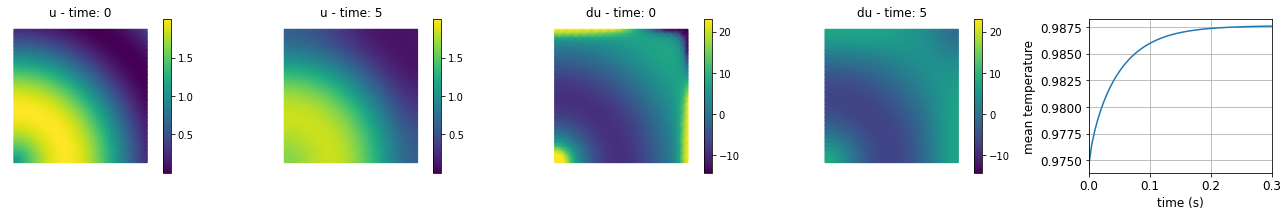

average time for computing x: 1.17 s
(61, 1089) (61, 1089)


In [4]:
# generate training set
data = []
param = []
total_time = 0
case_id = 1
for i in p1_arr:
    for j in p2_arr:
        snapshot = {}
        param.append(np.array([i, j]))
        params['pde']['width'] = i
        params['pde']['height'] = j
        print(f'case {case_id} - width: {i}, height: {j}')
        
        # compute u and du
        time0 = time()
        subprocess.call([params['pde']['exe_file'],
                         '-m', params['pde']['m_file'],
                         '-uf', params['pde']['u_file'],
                         '-rf', params['pde']['res_file'],
                         '-r', str(params['pde']['rl']),
                         '-o', str(params['pde']['order']),
                         '-s', str(params['pde']['ODEsolver']),
                         '-tf', str(params['pde']['tstop']),
                         '-dt', str(params['pde']['dt']),
                         '-h0', str(params['pde']['height']),
                         '-w0', str(params['pde']['width']),
                         '-k', str(params['pde']['kappa']),
                         '-a', str(params['pde']['alpha']),
                         '-x1', str(params['pde']['x1']),
                         '-x2', str(params['pde']['x2']),
                         '-no-vis',
                         '-no-visit',])
        time1 = time()
        t_fom = time1 - time0
        total_time += t_fom
        
        # collect data
        snapshot = {}
        u_all = []
        du_all = []
        for k in range(int(nt)):
            u = np.loadtxt(f'./ex16-u_{k:d}.gf', skiprows=5, dtype='float')
            u_all.append(u)
            
        u_all = np.vstack(u_all)
        du_all = derivative(u_all, tstop)
    
        snapshot['x'] = u_all
        snapshot['dx'] = du_all
        snapshot['t'] = np.linspace(0,tstop,u_all.shape[0])
        snapshot['time_fom'] = t_fom
        print(u_all.min(), u_all.max(), du_all.min(), du_all.max())
        data.append(snapshot)
        
        # triangulation for plotting
        # will generate vertex.txt that contains nodal coordinates
        if case_id == 1:
            mesh = pd.read_csv('ex16.mesh')
            idx = mesh[mesh.iloc[:,0].str.startswith('vertices')].index[0]
            vert = mesh.iloc[idx+3:,:] # nodal coordinates
            vert.to_csv(data_path + '/vertex.txt', index=False, header=False)
            vert = np.array([x.split(' ') for x in vert.to_numpy()[:,0]], dtype=float)
            triang = tri.Triangulation(vert[:,0], vert[:,1])
            
        if plot_fig:
            plot_u(u_all, du_all)
        case_id += 1
        
data_all = {}
data_all['data'] = data
data_all['param'] = param
print(f"average time for computing x: {total_time/len(data_all['data']):.2f} s")
print(snapshot['x'].shape, snapshot['dx'].shape) 

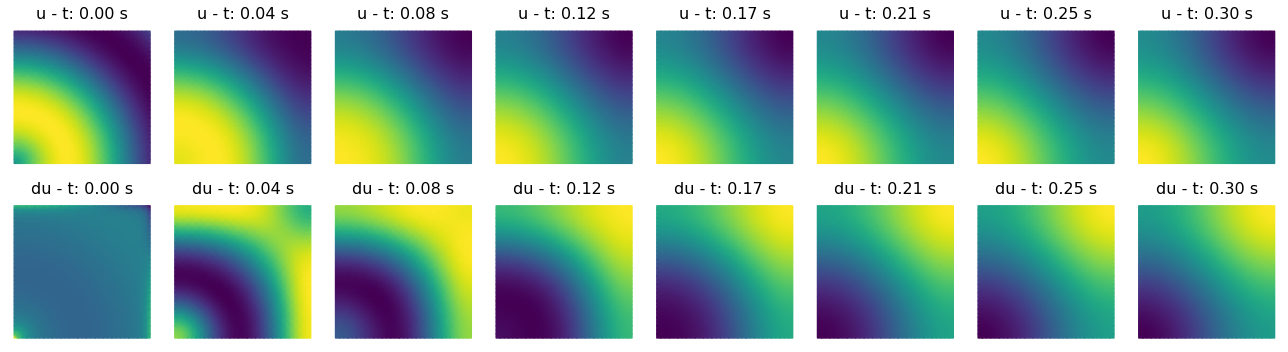

In [5]:
nplot = 8
step_list = np.linspace(0,nt-1,nplot,dtype=int)

fig = plt.figure(figsize=(18,5))
for i,step in enumerate(step_list):
    ax = fig.add_subplot(2,nplot,i+1)
    ax = plt.gca()
    tpc = ax.tripcolor(triang, u_all[step], shading='gouraud')
    ax.set_title(f'u - t: {step/nt*tstop:.2f} s',fontsize=16)
    plt.axis('off')
    
for i,step in enumerate(step_list):
    ax = fig.add_subplot(2,nplot,i+1+nplot)
    ax = plt.gca()
    tpc = ax.tripcolor(triang, du_all[step], shading='gouraud')
    ax.set_title(f'du - t: {step/nt*tstop:.2f} s',fontsize=16)
    plt.axis('off')
    
plt.tight_layout()
# plt.savefig('./ex16_multisteps.png')

In [6]:
# remove *.gf and *.mesh files output from executable
import glob
files = glob.glob('ex16*')
subprocess.call(['rm', '-r'] + files)

0

In [7]:
# save data
if save_data:
    num_case = len(data)
    if num_case > 1:
        pickle.dump(data_all, open(data_path + f"/local{num_case}_tstop{tstop:.1f}c.p", "wb"))
    else:
        pickle.dump(data_all, open(data_path + f"/local{num_case}_p1{p1_arr[0]:.1f}_p2{p2_arr[0]:.1f}_tstop{tstop:.1f}.p", "wb"))